In [1]:
import numpy as np
import ray
import matplotlib.pyplot as plt
import time
from utils import *
from procedures import *

# set figure font
plt.rcParams["font.sans-serif"] = "DejaVu Sans"
plt.rcParams["mathtext.default"]  = "it"
plt.rcParams["mathtext.fontset"]  = "dejavusans"

In [2]:
# Number of parallel threads to be used
# Shut down any existing Ray processes
# Initialize Ray with the specified number of parallel threads

num_cpus=96
ray.shutdown()
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

2023-12-21 20:28:13,608	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


In [12]:
seed = 20221203
np.random.seed(seed)

n_replications = 2000

# problem size k=2**l. l = min_power,..., max_power
min_power = 2
max_power = 12

# parameters of the problem configuration
gamma = 0.1
var = 0.25

In [13]:
OCBA_results = []
Greedy_results =  []

In [14]:
rng = np.random.default_rng(seed)

for power in np.arange(min_power, max_power+1):
    # generate problem instance for k = 2**power per each replication
    generators = [SCCVGenerator(2**power, gamma, var) for i in range(n_replications)]
    # the total sampling budget is set as N=n*k
    n = 100
    # finish the experiments and then estimate the PCS (or PGS) for k
    PCS, PGS = parallel_experiments(rng,  generators, policy=OCBA, remote_policy=remote_OCBA,  
                                args={"n":n})
    OCBA_results.append(PCS)
    
    n0 = 1
    ng = 99
    PCS, PGS = parallel_experiments(rng,  generators, policy=EFG, remote_policy=remote_EFG,  
                                args={"n0":n0, "ng":ng})
    Greedy_results.append(PCS)

--------New experiments with  k=4----------------------
Start to simulate... at Thu Dec 21 20:29:59 2023
PCS:0.826, PGS:0.826
Total time used: 1.1350250244140625s, simulation ends at Thu Dec 21 20:29:59 2023
--------New experiments with  k=4----------------------
Start to simulate... at Thu Dec 21 20:30:00 2023
PCS:0.4475, PGS:0.4475
Total time used: 1.2218115329742432s, simulation ends at Thu Dec 21 20:30:00 2023
--------New experiments with  k=8----------------------
Start to simulate... at Thu Dec 21 20:30:01 2023
PCS:0.7105, PGS:0.7105
Total time used: 1.0482425689697266s, simulation ends at Thu Dec 21 20:30:01 2023
--------New experiments with  k=8----------------------
Start to simulate... at Thu Dec 21 20:30:02 2023
PCS:0.3365, PGS:0.3365
Total time used: 1.1711058616638184s, simulation ends at Thu Dec 21 20:30:02 2023
--------New experiments with  k=16----------------------
Start to simulate... at Thu Dec 21 20:30:03 2023
PCS:0.561, PGS:0.561
Total time used: 1.0794458389282227

In [15]:
OCBA_results, Greedy_results

([0.826, 0.7105, 0.561, 0.39, 0.2315, 0.0955, 0.02, 0.002, 0.0, 0.0, 0.0],
 [0.4475,
  0.3365,
  0.282,
  0.2805,
  0.247,
  0.2385,
  0.2635,
  0.244,
  0.227,
  0.2355,
  0.245])

In [16]:
# results drawn from the above experiments for producing the Figure 1
# Greedy_results, OCBA_results = ([0.4475,
#   0.3365,
#   0.282,
#   0.2805,
#   0.247,
#   0.2385,
#   0.2635,
#   0.244,
#   0.227,
#   0.2355,
#   0.245],
#  [0.826, 0.7105, 0.561, 0.39, 0.2315, 0.0955, 0.02, 0.002, 0.0, 0.0, 0.0])

In [17]:
results = [Greedy_results, OCBA_results]

In [18]:
labels = ['Greedy, $B=100k$', 'OCBA, $B=100k$']

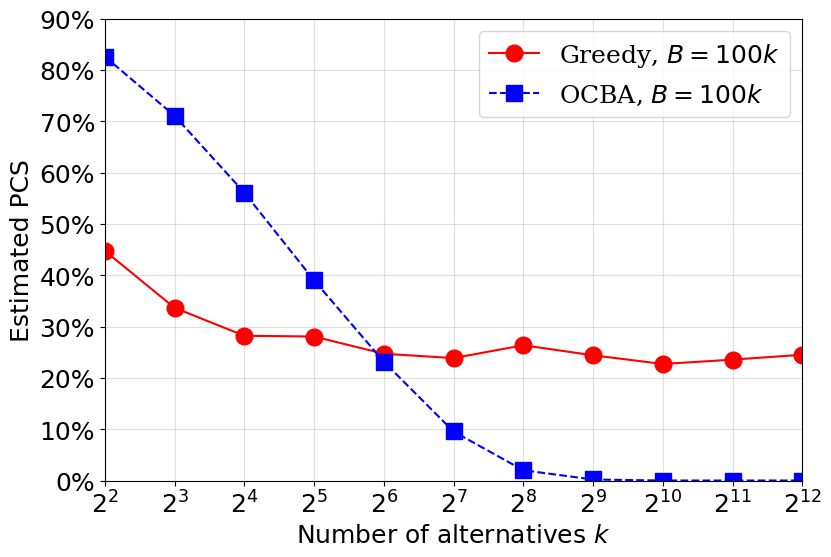

In [19]:

powers = np.arange(min_power, max_power+1)

colors = ["r" ,"b", "c", "m", "k"]
markers = ["o", "s", "d", "p", "*", "D"]
line_styles = ["-", "--", "-.",":",'-']
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
threslines = [0.225, 0.313]
fig = plt.figure(figsize=(9, 6))

for i, result in enumerate(results[:4]):
    plt.plot(powers, result, line_styles[i], marker=markers[i], markersize=12,  color=colors[i], label=labels[i])

plt.xlim(min_power, max_power)
xticks = np.arange(min_power, max_power+1)
xticklabels = ["2^{"+str(power)+"}" for power in xticks]
#xticklabels = [str(2 ** (power)) for power in xticks]
xticklabels = ["$"+power_label+"$" for power_label in xticklabels]
plt.xticks(powers, xticklabels,fontsize=18)

min_result = np.min(results)
max_result = np.max(results)

min_level = (min_result // 0.1-1)*0.1
max_level = (max_result // 0.1 + 1)*0.1

plt.ylim(0,max_level)
yticks = np.arange(0., max_level+0.1, 0.1)
yticklabels = ["%.0f"%(tick*100)+"%" for tick in yticks]
plt.yticks(yticks, yticklabels, fontsize=18)

plt.legend(prop={'family': 'serif',"size":18})
plt.xlabel("Number of alternatives $k$", size=18)
plt.ylabel("Estimated PCS", size=18)
# plt.title("Problem 1")
plt.grid(alpha=0.4)
plt.savefig("Figure_1.pdf", bbox_inches ="tight")
plt.show()